In [24]:
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from scipy.interpolate import griddata
import matplotlib.pyplot as plt


This will calculte the curviture and gaussian curviture of LD or bilayer membranes



In [241]:
def loader(topology_path, trajectory_path):
    u = mda.Universe(topology_path, trajectory_path)
    return u

u1 = loader('trajs/gro.gro', 'trajs/skip.xtc')
u2 = loader('trajs/gro.gro', 'trajs/skipc.xtc')
u3 = loader('trajs/ld.psf', 'trajs/3mn.dcd')

In [247]:

def create_surface_array(u, grid_x, grid_y, upper=atoms):
    # upper = u.select_atoms(selection_string)
    x_positions = upper.positions[:, 0]  # X coordinates
    y_positions = upper.positions[:, 1]  # Y coordinates
    z_positions = upper.positions[:, 2]  # Z coordinates (heights)
    # Create grid
    grid_x_values = np.linspace(grid_x[0], grid_x[1], grid_x[2])
    grid_y_values = np.linspace(grid_y[0], grid_y[1], grid_y[2])
    X, Y = np.meshgrid(grid_x_values, grid_y_values)
    points = np.column_stack((x_positions, y_positions))
    Z = griddata(points, z_positions, (X, Y), method='cubic')

    return X, Y, Z

def grid_array(u, atoms):
    grid_x = (0, u.dimensions[0], 100)  # Customize grid size and resolution
    grid_y = (0, u.dimensions[1], 100)
    X, Y, Z = create_surface_array(u1,  grid_x, grid_y, upper=atoms)
    return X, Y, Z

def calculate_curvatures(Z, dx, dy):
    # Calculate first derivatives
    Zx = np.gradient(Z, axis=1, edge_order=1) / dx
    Zy = np.gradient(Z, axis=0, edge_order=1) / dy
    # Calculate second derivatives
    Zxx = np.gradient(Zx, axis=1, edge_order=1) / dx
    Zxy = np.gradient(Zx, axis=0, edge_order=1) / dy
    Zyy = np.gradient(Zy, axis=0, edge_order=1) / dy
    # Calculate mean curvature (H) and Gaussian curvature (K)
    H = (Zxx * (1 + Zy**2) - 2 * Zx * Zy * Zxy + Zyy * (1 + Zx**2)) / (2 * (1 + Zx**2 + Zy**2)**1.5)
    K = (Zxx * Zyy - Zxy**2) / (1 + Zx**2 + Zy**2)**2
    return H, K

def grid_curvatures(u, atoms):
    grid_x = (0, u.dimensions[0], 100)  # Customize grid size and resolution
    grid_y = (0, u.dimensions[1], 100)
    X, Y, Z = grid_array(u, atoms)
    dx = (grid_x[1] - grid_x[0]) / (grid_x[2] - 1)
    dy = (grid_y[1] - grid_y[0]) / (grid_y[2] - 1)
    H, K = calculate_curvatures(Z, dx, dy)
    return H, K

def frame_iter(u):
    H_values = []
    K_values = []

    for ts in u.trajectory:
        H, K = grid_curvatures(u, atoms)
        H_values.append(H)
        K_values.append(K)

    return H_values, K_values

def surface(u, atoms):
    X_list = []
    Y_list = []
    Z_list = []
    for ts in u.trajectory:
        X, Y, Z = grid_array(u, atoms)  # Assuming grid_array is defined elsewhere
        X_list.append(X)
        Y_list.append(Y)
        Z_list.append(Z)

    return X_list, Y_list, Z_list


In [248]:

halfz = u1.dimensions[2] / 2
atoms = u1.select_atoms('name P and prop z > {}'.format(halfz))
H_c36, K_c36 = frame_iter(u1)
X_c36, Y_c36, Z_c36 = surface(u1, atoms)


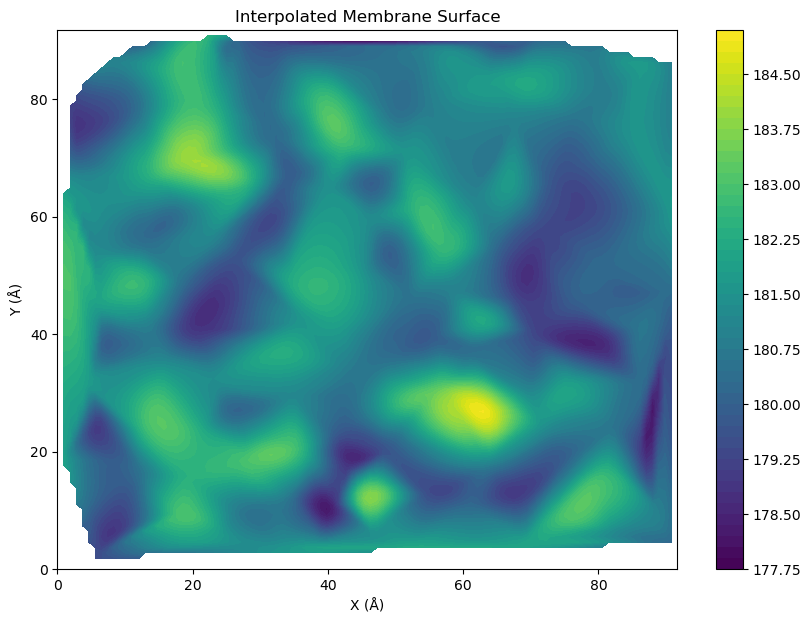

In [249]:
# Plot to check the surface
X, Y, Z = grid_array(u1,atoms)

plt.figure(figsize=(10, 7))
plt.contourf(X, Y, Z, levels=50, cmap='viridis')
plt.colorbar()
plt.title('Interpolated Membrane Surface')
plt.xlabel('X (Å)')
plt.ylabel('Y (Å)')
plt.show()

In [229]:
import numpy as np
import matplotlib.pyplot as plt

def analyze_and_plot_curvature(H_values, K_values):
    # Convert input data to numpy arrays if they aren't already
    H_values = np.array(H_values)
    K_values = np.array(K_values)

    # Calculations for Mean Curvature
    mean_curvature_per_frame = np.nanmean(H_values, axis=(1, 2))
    std_dev_curvature_per_frame = np.nanstd(H_values, axis=(1, 2))
    min_curvature_per_frame = np.nanmin(H_values, axis=(1, 2))
    max_curvature_per_frame = np.nanmax(H_values, axis=(1, 2))
    total_abs_H_per_frame = np.nansum(np.abs(H_values), axis=(1, 2))
    effective_area_H = np.sum(~np.isnan(H_values), axis=(1, 2))
    normalized_total_abs_H_per_frame = total_abs_H_per_frame / effective_area_H

    # Calculations for Gaussian Curvature
    total_abs_K_per_frame = np.nansum(np.abs(K_values), axis=(1, 2))
    effective_area_K = np.sum(~np.isnan(K_values), axis=(1, 2))
    normalized_total_abs_K_per_frame = total_abs_K_per_frame / effective_area_K

    # Plotting Mean Curvature statistics over time
    plt.figure(figsize=(14, 7))
    plt.subplot(2, 2, 1)
    plt.plot(mean_curvature_per_frame, label='Mean Curvature')
    plt.xlabel('Frame Number')
    plt.ylabel('Mean Curvature (1/m)')
    plt.title('Mean Curvature Over Time')
    plt.grid(True)
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(std_dev_curvature_per_frame, color='r', label='Standard Deviation of Curvature')
    plt.xlabel('Frame Number')
    plt.ylabel('Standard Deviation (1/m)')
    plt.title('Curvature Variability Over Time')
    plt.grid(True)
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(min_curvature_per_frame, color='g', label='Min Curvature')
    plt.xlabel('Frame Number')
    plt.ylabel('Min Curvature (1/m)')
    plt.title('Minimum Curvature Over Time')
    plt.grid(True)
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(max_curvature_per_frame, color='m', label='Max Curvature')
    plt.xlabel('Frame Number')
    plt.ylabel('Max Curvature (1/m)')
    plt.title('Maximum Curvature Over Time')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Plotting Total and Normalized Absolute Curvatures over time
    plt.figure(figsize=(14, 10))
    plt.subplot(2, 2, 1)
    plt.plot(total_abs_H_per_frame, label='Total Absolute Mean Curvature')
    plt.xlabel('Frame Number')
    plt.ylabel('Total Absolute Curvature (1/m)')
    plt.title('Total Absolute Mean Curvature Over Time')
    plt.grid(True)
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(normalized_total_abs_H_per_frame, label='Normalized Total Absolute Mean Curvature')
    plt.xlabel('Frame Number')
    plt.ylabel('Normalized Total Curvature (1/m²)')
    plt.title('Normalized Total Absolute Mean Curvature Over Time')
    plt.grid(True)
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(total_abs_K_per_frame, label='Total Absolute Gaussian Curvature')
    plt.xlabel('Frame Number')
    plt.ylabel('Total Absolute Curvature (1/m²)')
    plt.title('Total Absolute Gaussian Curvature Over Time')
    plt.grid(True)
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(normalized_total_abs_K_per_frame, label='Normalized Total Absolute Gaussian Curvature')
    plt.xlabel('Frame Number')
    plt.ylabel('Normalized Total Curvature (1/m³)')
    plt.title('Normalized Total Absolute Gaussian Curvature Over Time')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

# Usage example:
# Assuming H_values and K_values are defined and loaded with your curvature data



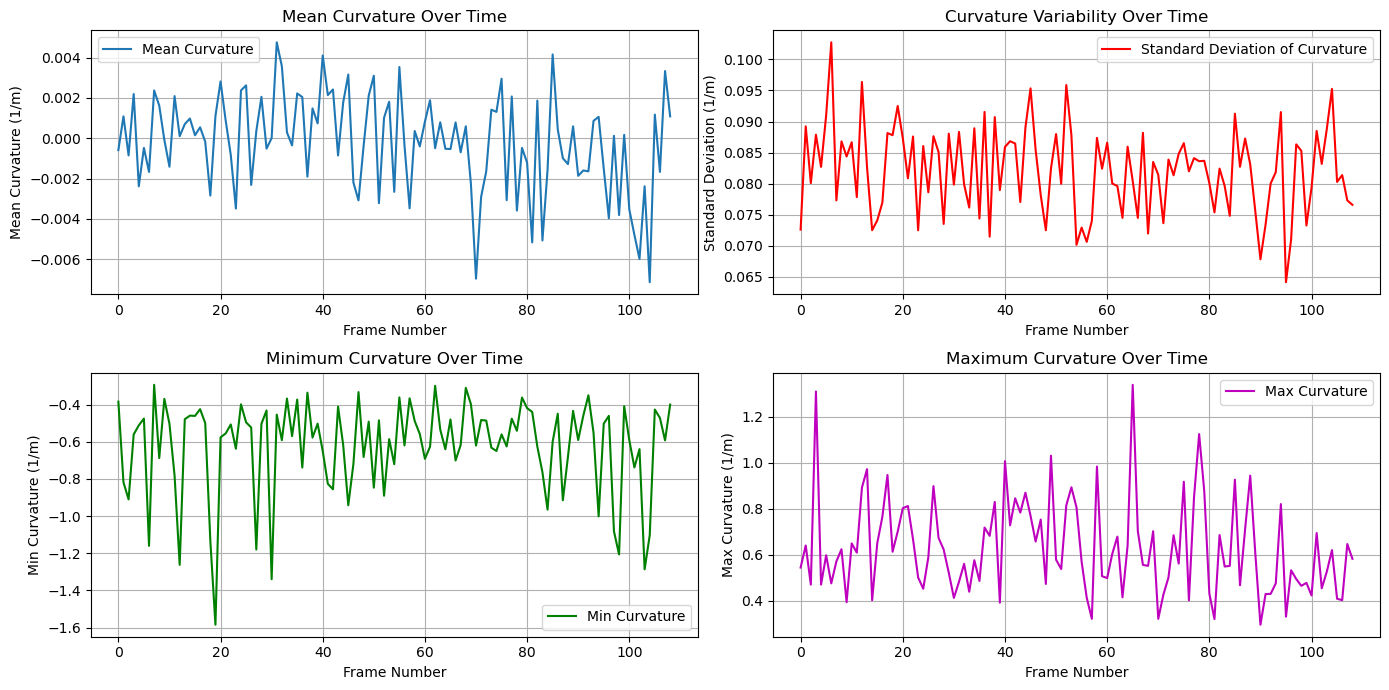

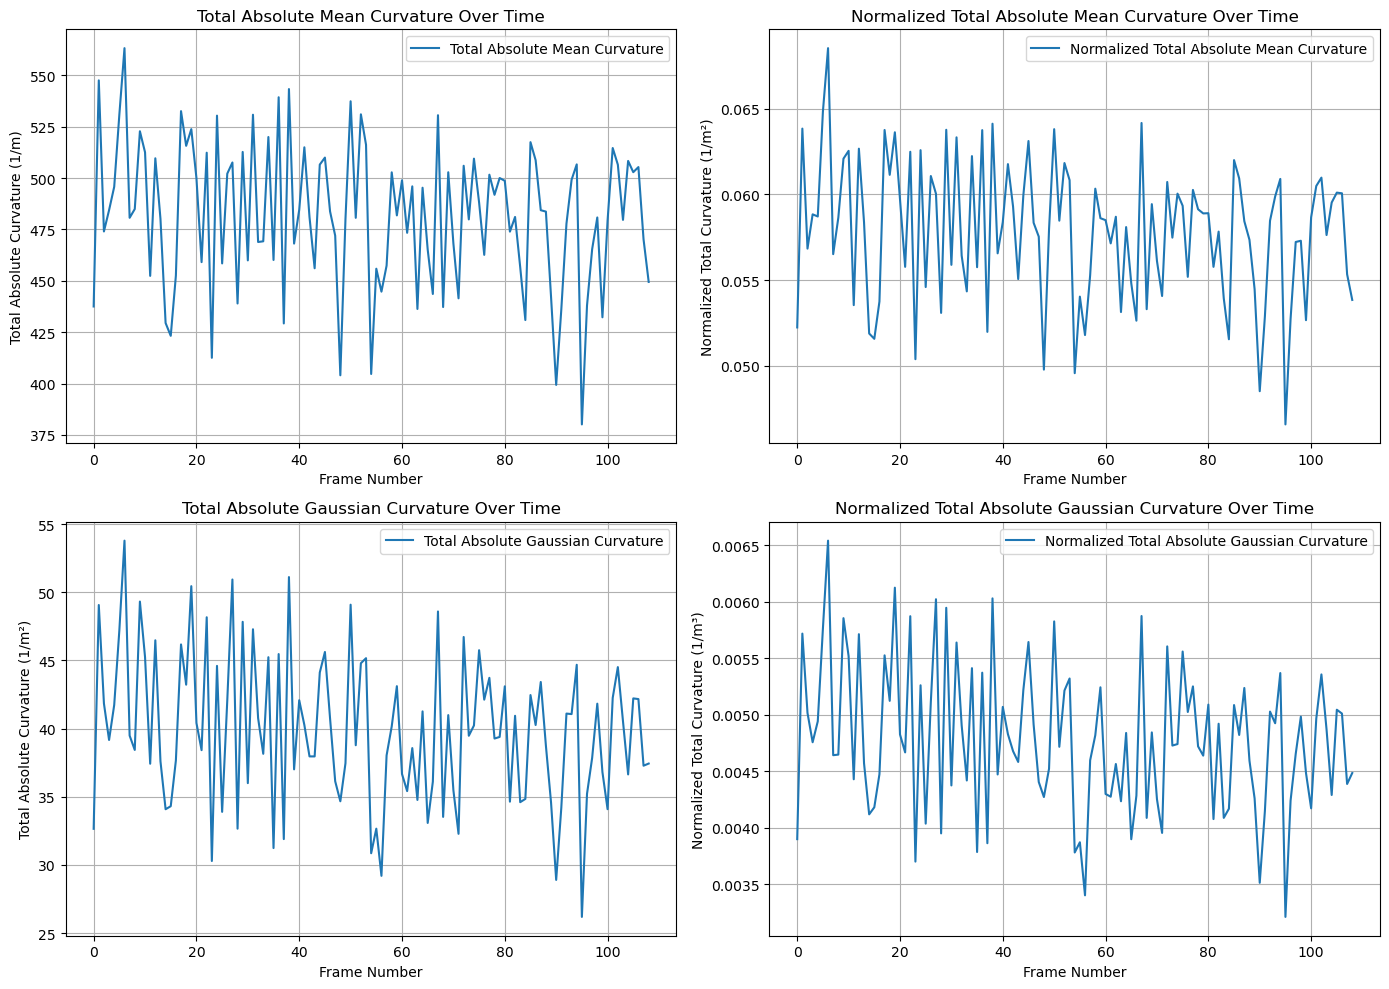

In [230]:
analyze_and_plot_curvature(H_c36, K_c36)

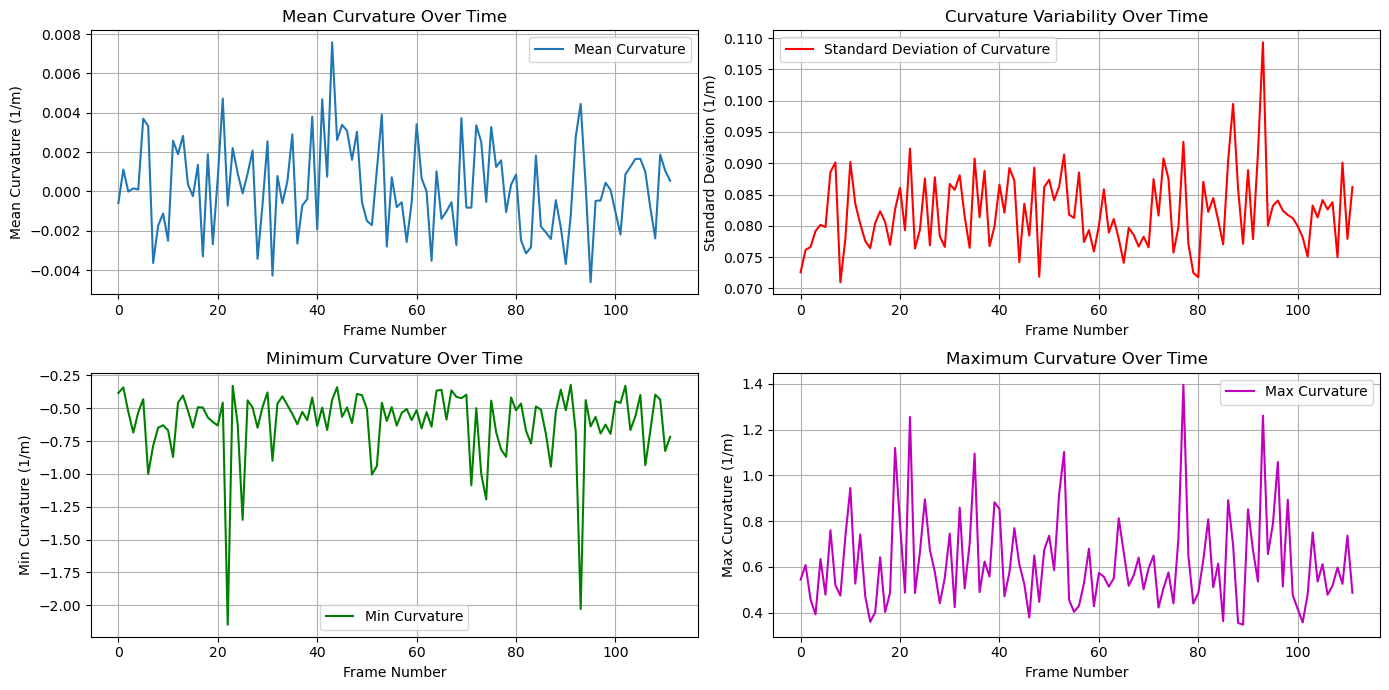

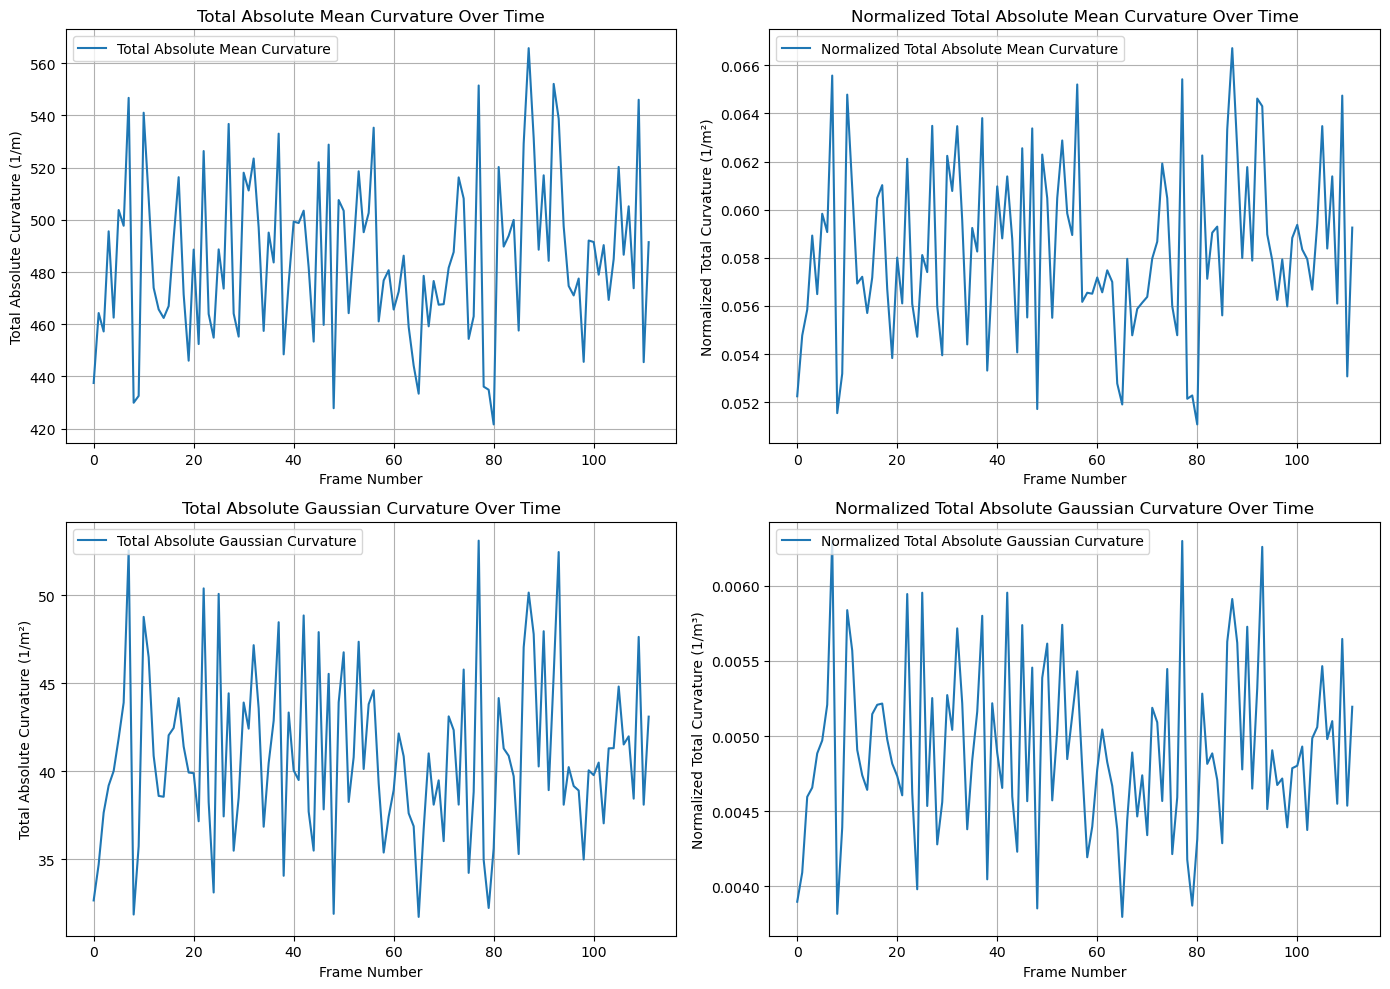

In [235]:
analyze_and_plot_curvature(H_c36c, K_c36c)

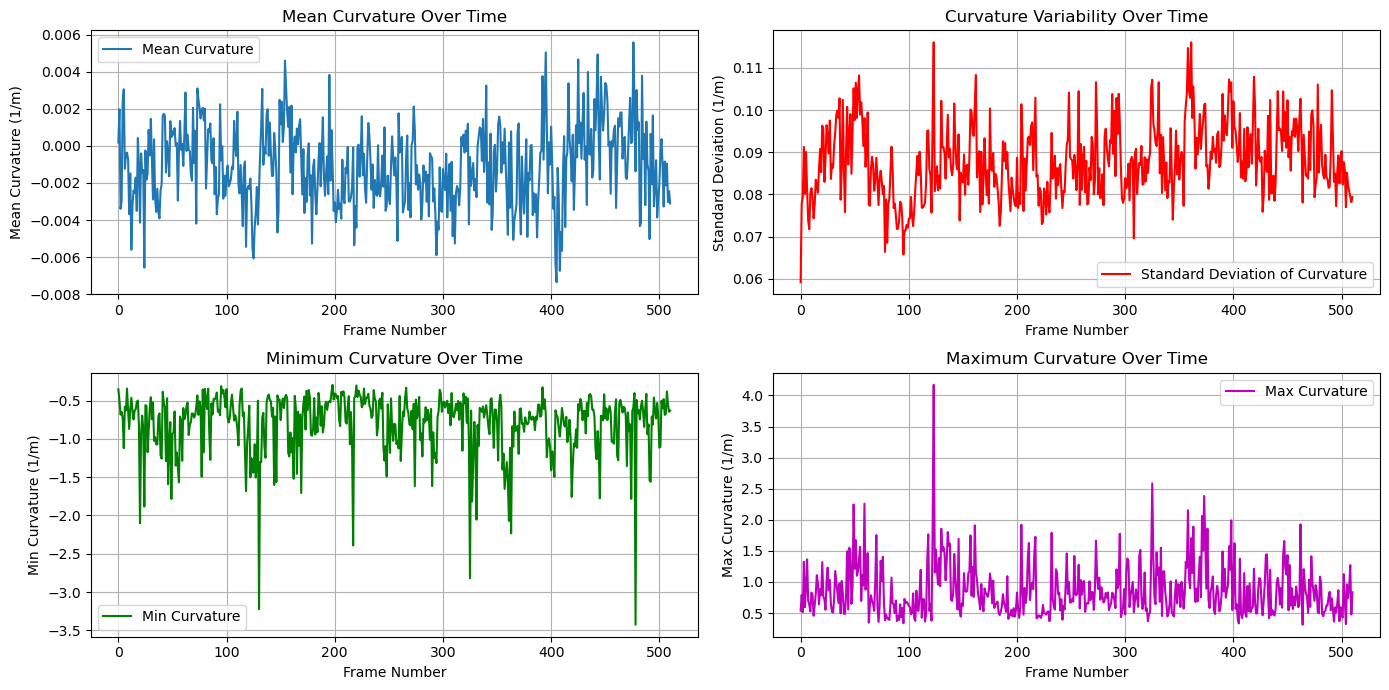

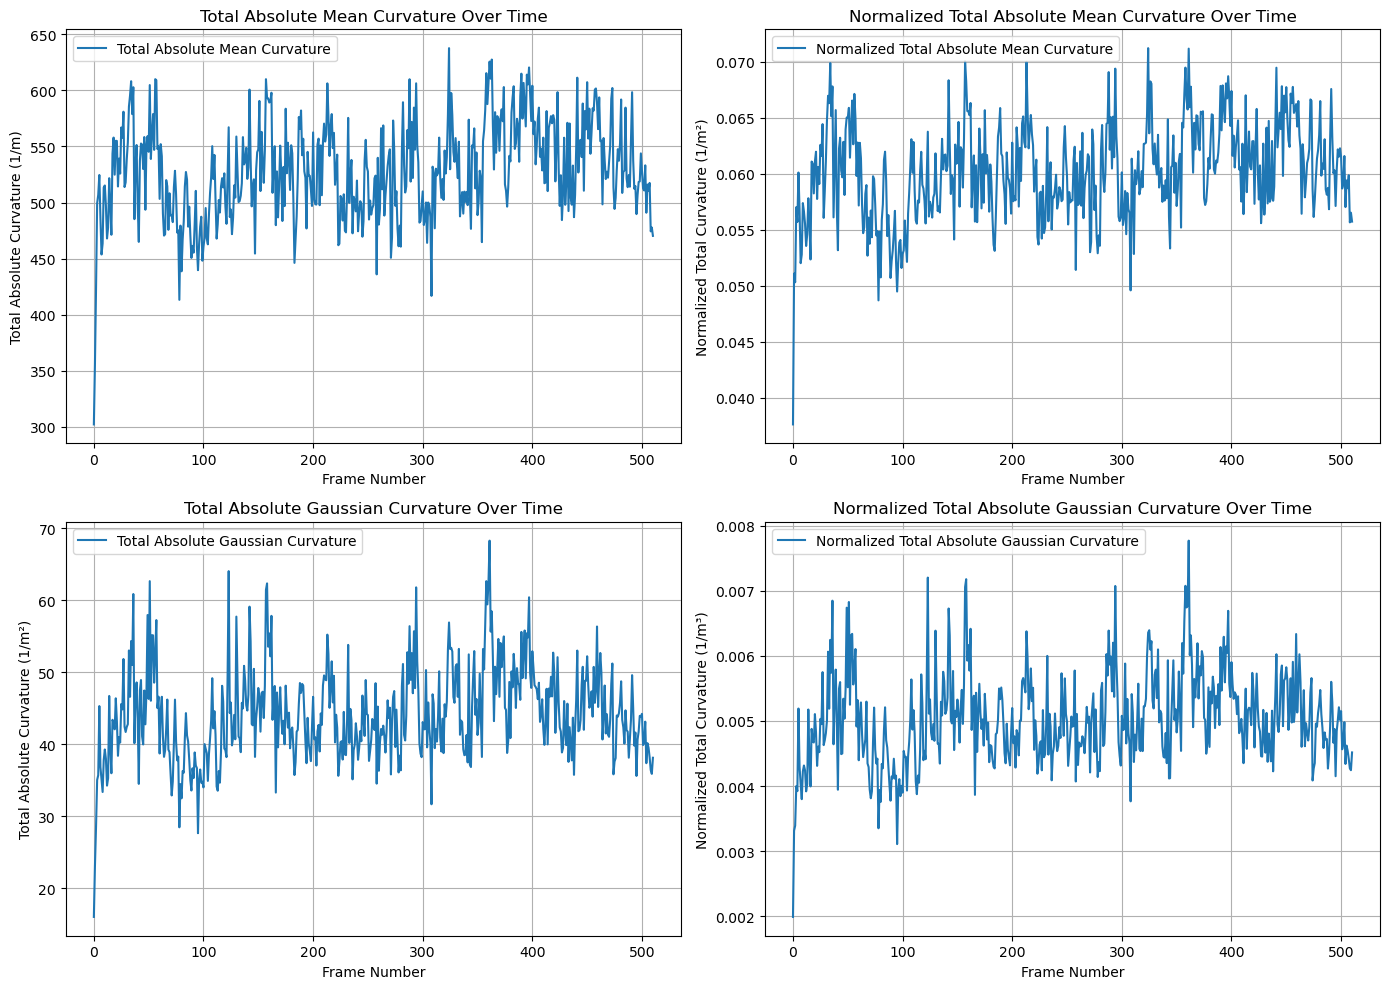

In [236]:
analyze_and_plot_curvature(H_drude, K_drude)

In [239]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

# Ensure H_values is a numpy array, in case it's not already
H_values = np.array(K_c36)

fig, ax = plt.subplots()
# Set the color limits based on the non-NaN min and max values
vmin = np.nanmin(H_values)
vmax = np.nanmax(H_values)
cax = ax.imshow(H_values[0, :, :], cmap='viridis', vmin=vmin, vmax=vmax)
fig.colorbar(cax)

def update(frame):
    cax.set_data(H_values[frame, :, :])
    ax.set_title(f"Frame {frame + 1}")
    return cax,

# Create the animation using PillowWriter
ani = FuncAnimation(fig, update, frames=len(H_values), blit=True, repeat=False)

# Save the animation as a GIF using PillowWriter
writer = PillowWriter(fps=10)
ani.save('curvature_animation_c36_more.gif', writer=writer)
plt.close()


In [240]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

# Ensure H_values is a numpy array
H_values = np.array(K_c36)

fig, ax = plt.subplots()
# Adjust vmin and vmax to enhance contrast
median_value = np.nanmedian(H_values)
deviation = np.nanpercentile(H_values, 75) - np.nanpercentile(H_values, 25)  # Interquartile range

vmin = median_value - 1.5 * deviation
vmax = median_value + 1.5 * deviation

# Use a diverging colormap to highlight differences
cax = ax.imshow(H_values[0, :, :], cmap='RdBu', vmin=vmin, vmax=vmax)
fig.colorbar(cax)

def update(frame):
    cax.set_data(H_values[frame, :, :])
    ax.set_title(f"Frame {frame + 1}")
    return cax,

# Create the animation using PillowWriter
ani = FuncAnimation(fig, update, frames=len(H_values), blit=True, repeat=False)

# Save the animation as a GIF using PillowWriter
writer = PillowWriter(fps=10)
ani.save('curvature_animation_enhanced.gif', writer=writer)
plt.close()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

def animate_surface(X, Y, Z):
    # Initialize the plot with the first frame's data
    fig, ax = plt.subplots(figsize=(10, 7))
    # levels = np.linspace(np.nanmin(Z), np.nanmax(Z), 50)  # Define contour levels globally
    levels = 50

    # Create the initial contour plot
    contour = ax.contourf(X[0], Y[0], Z[0], levels=levels, cmap='viridis')
    cbar = fig.colorbar(contour, ax=ax)
    cbar.set_label('Z value')
    ax.set_title('Interpolated Membrane Surface - Frame 1')
    ax.set_xlabel('X (Å)')
    ax.set_ylabel('Y (Å)')

    def update(frame):
        # Update the contour plot for each frame
        ax.clear()
        contour = ax.contourf(X[frame], Y[frame], Z[frame], levels=levels, cmap='viridis')
        ax.set_title(f'Interpolated Membrane Surface - Frame {frame + 1}')
        ax.set_xlabel('X (Å)')
        ax.set_ylabel('Y (Å)')
        return contour,

    # Create the animation
    ani = FuncAnimation(fig, update, frames=len(Z), blit=True, repeat=False)

    # Save the animation as a GIF using PillowWriter
    writer = PillowWriter(fps=10)
    ani.save('membrane_surface_animation_drude.gif', writer=writer)
    plt.close()

# Assuming X, Y, and Z are your lists of arrays for each frame
# Example usage, make sure X, Y, Z are loaded appropriately
animate_surface(X, Y, Z)


In [216]:
print(X[0].shape)  # Should output (100, 100)
print(Y[0].shape)  # Should output (100, 100)
print(Z[0].shape)  # Should output (100, 100)


(100,)
(100,)
(100,)


TypeError: Input z must be 2D, not 3D

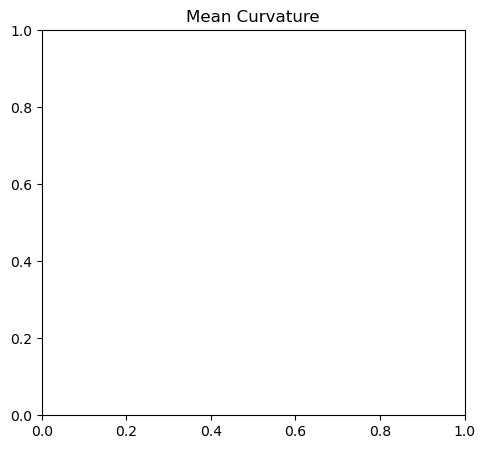

In [250]:
# You can now visualize the mean and Gaussian curvatures
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Mean Curvature')
plt.contourf(X, Y, H, levels=50, cmap='viridis')
plt.colorbar()
plt.xlabel('X (Å)')
plt.ylabel('Y (Å)')

plt.subplot(1, 2, 2)
plt.title('Gaussian Curvature')
plt.contourf(X, Y, K, levels=50, cmap='viridis')
plt.colorbar()
plt.xlabel('X (Å)')
plt.ylabel('Y (Å)')

plt.tight_layout()
plt.show()

In [112]:
mean_curvature_K1 = np.nanmean(K)
std_dev_curvature_K1 = np.nanstd(K)



In [113]:
print('Mean Curvature:', mean_curvature_K1)

Mean Curvature: 2.237733483970984e-05


In [114]:
print('Standard Deviation of Curvature:', std_dev_curvature_K1)

Standard Deviation of Curvature: 0.004353843518020268


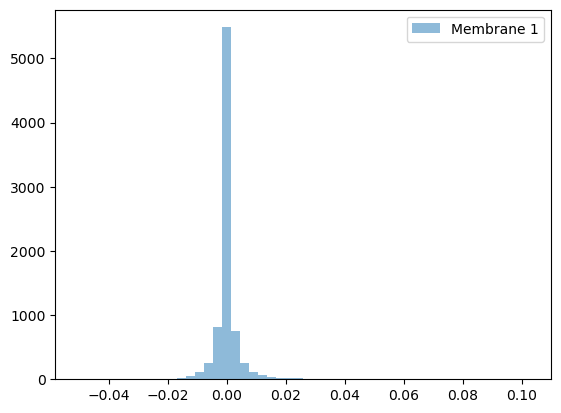

In [115]:
plt.hist(K.flatten(), bins=50, alpha=0.5, label='Membrane 1')
# plt.hist(K2.flatten(), bins=50, alpha=0.5, label='Membrane 2')
plt.legend()
plt.show()


In [116]:
total_curvature_K1 = np.nansum(K) * dx * dy  # Assuming dx, dy are the grid spacings



In [117]:
total_curvature_K1

0.15422824758287584

In [118]:
max_curvature_K1 = np.nanmax(K)
min_curvature_K1 = np.nanmin(K)


print('Max Curvature:', max_curvature_K1)
print('Min Curvature:', min_curvature_K1)

Max Curvature: 0.10229017020643795
Min Curvature: -0.05060969259860033


In [119]:

total_absolute_gaussian_curvature = np.nansum(np.abs(K))

total_absolute_mean_curvature = np.nansum(np.abs(H))

# Normalizing by the number of non-NaN entries
effective_area_K = np.sum(~np.isnan(K))
normalized_total_curvature_K = total_absolute_gaussian_curvature / effective_area_K

effective_area_H = np.sum(~np.isnan(H))
normalized_total_curvature_H = total_absolute_mean_curvature / effective_area_H


print('Total Absolute Gaussian Curvature:', total_absolute_gaussian_curvature)
print('Total Absolute Mean Curvature:', total_absolute_mean_curvature)
print('Normalized Total Curvature (Gaussian):', normalized_total_curvature_K)
print('Normalized Total Curvature (Mean):', normalized_total_curvature_H)

Total Absolute Gaussian Curvature: 15.994011257021816
Total Absolute Mean Curvature: 302.2014460835323
Normalized Total Curvature (Gaussian): 0.001990790547301695
Normalized Total Curvature (Mean): 0.03761531566884893


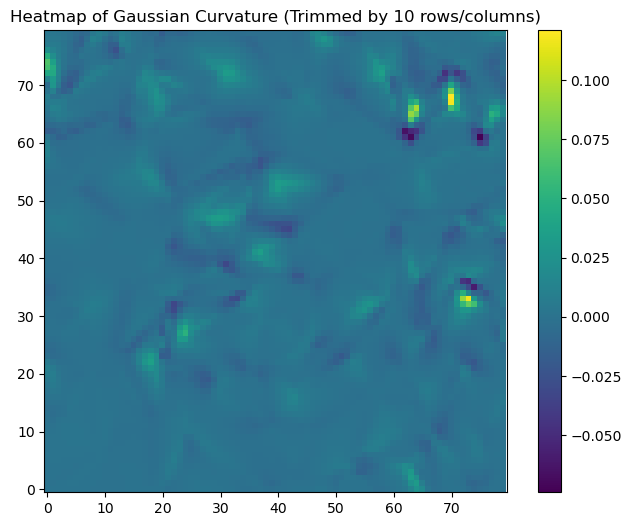

Trim Size: 5
Min: -0.07412221692219984, Max: 0.12099551822253439, Mean: 5.2382911540689834e-05, NaN Count: 139
Trim Size: 10
Min: -0.07412221692219984, Max: 0.12099551822253439, Mean: 0.00020985683066117035, NaN Count: 0
Trim Size: 15
Min: -0.06899752368101712, Max: 0.12099551822253439, Mean: 0.00019025612373854543, NaN Count: 0


In [158]:
def trim_and_analyze(K, trim_size):
    # Trim the array
    K_trimmed = K[trim_size:-trim_size, trim_size:-trim_size]
    
    # Calculate statistics
    min_val = np.nanmin(K_trimmed)
    max_val = np.nanmax(K_trimmed)
    mean_val = np.nanmean(K_trimmed)
    nan_count = np.isnan(K_trimmed).sum()
    
    return K_trimmed, min_val, max_val, mean_val, nan_count

# Test different trim sizes
trim_sizes = [5, 10, 15]
results = {}

for size in trim_sizes:
    trimmed_K, min_val, max_val, mean_val, nan_count = trim_and_analyze(K, size)
    results[size] = (trimmed_K, min_val, max_val, mean_val, nan_count)
    
    # Plot the heatmap for the most substantial trim size
    if size == 10:
        plt.figure(figsize=(8, 6))
        plt.imshow(trimmed_K, cmap='viridis', origin='lower')
        plt.colorbar()
        plt.title(f'Heatmap of Gaussian Curvature (Trimmed by {size} rows/columns)')
        plt.show()

# Output the statistics for each trim size
for size, (trimmed_K, min_val, max_val, mean_val, nan_count) in results.items():
    print(f"Trim Size: {size}")
    print(f"Min: {min_val}, Max: {max_val}, Mean: {mean_val}, NaN Count: {nan_count}")


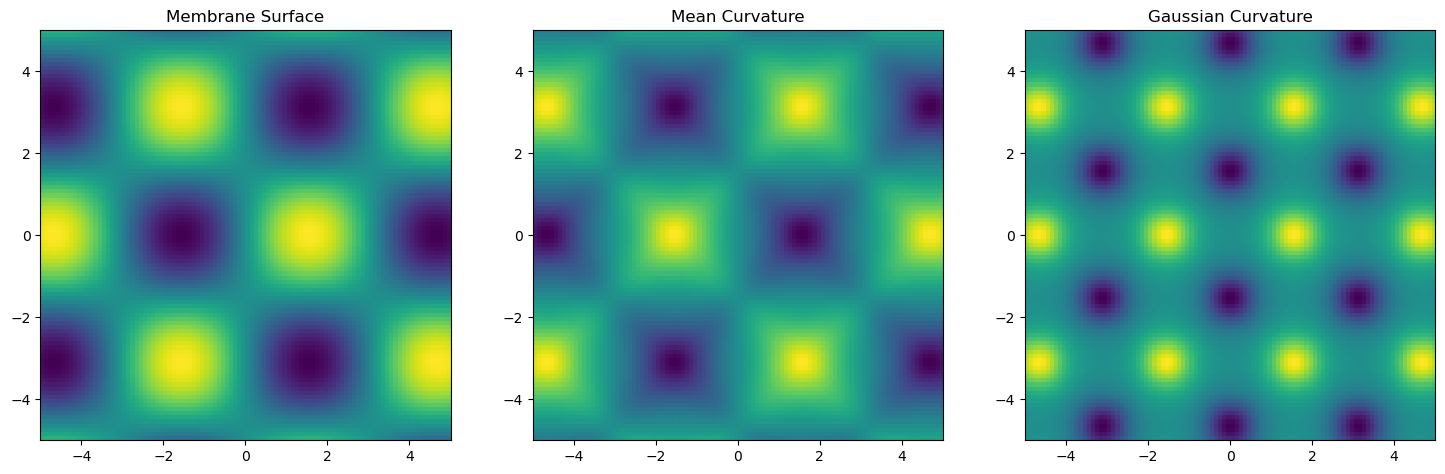

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Create a grid of points
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)

# Define the membrane surface as a function of x and y
# For this example, we use a simple sine function to simulate a wavy membrane
Z = np.sin(X) * np.cos(Y)

# Calculate first derivatives
Zx = np.gradient(Z, axis=1, edge_order=2) / np.gradient(X, axis=1, edge_order=2)
Zy = np.gradient(Z, axis=0, edge_order=2) / np.gradient(Y, axis=0, edge_order=2)

# Calculate second derivatives
Zxx = np.gradient(Zx, axis=1, edge_order=2) / np.gradient(X, axis=1, edge_order=2)
Zxy = np.gradient(Zx, axis=0, edge_order=2) / np.gradient(Y, axis=0, edge_order=2)
Zyy = np.gradient(Zy, axis=0, edge_order=2) / np.gradient(Y, axis=0, edge_order=2)

# Calculate mean curvature (H) and Gaussian curvature (K)
H = (Zxx * (1 + Zy**2) - 2 * Zx * Zy * Zxy + Zyy * (1 + Zx**2)) / (2 * (1 + Zx**2 + Zy**2)**1.5)
K = (Zxx * Zyy - Zxy**2) / (1 + Zx**2 + Zy**2)**2

# Plotting the surface and curvature
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
ax[0].imshow(Z, extent=(-5, 5, -5, 5), origin='lower')
ax[0].set_title('Membrane Surface')
ax[1].imshow(H, extent=(-5, 5, -5, 5), origin='lower')
ax[1].set_title('Mean Curvature')
ax[2].imshow(K, extent=(-5, 5, -5, 5), origin='lower')
ax[2].set_title('Gaussian Curvature')

plt.show()
